# Trabajo Final: Análisis Espacial con Python

### Melina Schamberger

👉 **Objetivo:**

El presente trabajo se propone indagar cómo se relaciona la desigualdad socioterritorial de la provincia de Buenos Aires con la distribución de instituciones de educación superior.



🗂 **Fuente de datos:**

*  Datos de Establecimientos Educativos disponibilizados públicamente por el  Gobierno d ela Provincia de Buenos Aires. Disponibles en [Datos Abiertos de la Provincia de Buenos Aires](https://catalogo.datos.gba.gob.ar/).
*  Geodata de Pobreza Crónica por Departamentos (multipolígonos) disponibilizados públicamente por [Poblaciones](https://poblaciones.org/).


## 🗃 0. Librerías 
Se cargan librerías necesarias para la lectura, transformación y limpieza de datos. 

In [46]:
!pip install geopandas
!pip install mapclassify
!pip install geopandas mapclassify contextily palettable

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt

In [48]:
import numpy as np
import pandas as pd  

In [49]:
import json
from shapely.geometry import shape

Se habilita el acceso al Drive donde se encuentran cargados los datos.

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📑 1. Datos
Se cargan los datos con los que se irá a trabajar. 

In [51]:
# establecimientos educativos de la provincia de Buenos Aires
superior = gpd.read_file('/content/drive/Shareddrives/schamberger_melina/Trabajos Prácticos/establecimientos_educativos.geojson')

In [52]:
# polígonos de departamentos con indicador de pobreza crónica
pobreza_cronica = pd.read_csv('/content/drive/Shareddrives/schamberger_melina/Trabajos Prácticos/Pobreza Crónica X Departamento.csv')

## 🛠 2.Exploración y transformación de datos

### A. Pobreza Crónica

Se comienza por analizar el df de pobreza crónica. 

> Cabe aclarar que, según los metadatos (2021) de la capa importada, "el concepto de pobreza crónica está basado en la idea de vulnerabilidad". En particular, se define como pobres crónicos al 10% de mayor vulnerabilidad de la población argentina. Este grupo incluye a hogares cuyas características son tales que no solo son pobres por ingreso en el presente, sino que es muy probable que hubieran sido pobres en todos los momentos del pasado, aun bajo circunstancias económicas más favorables. Naturalmente, estos hogares son también los más propensos a no poder superar situaciones de insuficiencia de ingreso en el futuro. 

> Para más detalles sobre la metodología del indicador, se sugiere consultar Gasparini, L. Gluzmann, P. y Tornarolli, L. (2019). Pobreza crónica en Argentina. Propuesta de medición y estimaciones. Documento de trabajo del CEDLAS. 

Se visualizan las primeras dos filas del DF: 

In [53]:
pobreza_cronica.head(2)

,Código de departamento Link,Provincia,Nombre del departamento,Hogares en situación de pobreza crónica,Personas en situación de pobreza crónica,% Personas en situación de pobreza crónica,% Hogares en situación de pobreza crónica,Nivel de Incidencia de pobreza crónica,Hogares,Población,...,Código de provincia,Nombre de provincia,Código de departamentos/comuna,Nombre de departamentos/comuna,Población total,Total de hogares,Latitud del centroide,Longitud del centroide,Superficie en km2,Geometría en GeoJSON
0,2001,2,Comuna 01,1166,6690,3.553219,1.380404,2,84468,188280,...,2,Ciudad Autónoma de Buenos Aires,2001,Comuna 1,205886,84468,-34.606365,-58.371709,17.774344,"{""type"":""Polygon"",""coordinates"":[[[-58.386301,..."
1,2002,2,Comuna 02,48,278,0.185248,0.065613,1,73156,150069,...,2,Ciudad Autónoma de Buenos Aires,2002,Comuna 2,157932,73156,-34.585876,-58.394997,6.276148,"{""type"":""Polygon"",""coordinates"":[[[-58.381109,..."


Se visualizan las columnas y el tipo de dato que alojan: 

In [54]:
pobreza_cronica.dtypes

Código de departamento Link                                                                int64
Provincia                                                                                  int64
Nombre del departamento                                                                   object
Hogares en situación de pobreza crónica                                                    int64
Personas en situación de pobreza crónica                                                   int64
% Personas en situación de pobreza crónica                                               float64
% Hogares en situación de pobreza crónica                                                float64
Nivel de Incidencia de pobreza crónica                                                     int64
Hogares                                                                                    int64
Población                                                                                  int64
PEA                           

Se observa la existencia de una columna con datos geo (*Geometría en GEOJSON*) que es de tipo float por lo que es necesario ajustar este punto. 

In [55]:
#Función para ajustar los datos: 
def parse_geom(geom_str):
    try:
        return shape(json.loads(geom_str))
    except (TypeError, AttributeError):  # Handle NaN and empty strings
        return None


In [56]:
#Se vuelven a cargar los datos de polígonos departamentales con el indicador de pobreza crónica
df = pd.read_csv('/content/drive/Shareddrives/schamberger_melina/Trabajos Prácticos/Pobreza Crónica X Departamento.csv')
df["Geometría en GeoJSON"] = df["Geometría en GeoJSON"].apply(parse_geom)
gdf = gpd.GeoDataFrame(df, geometry="Geometría en GeoJSON")
print(gdf.head())

   Código de departamento Link  Provincia Nombre del departamento  \
0                         2001          2               Comuna 01   
1                         2002          2               Comuna 02   
2                         2003          2               Comuna 03   
3                         2004          2               Comuna 04   
4                         2005          2               Comuna 05   

   Hogares en situación de pobreza crónica  \
0                                     1166   
1                                       48   
2                                      460   
3                                     1226   
4                                      217   

   Personas en situación de pobreza crónica  \
0                                      6690   
1                                       278   
2                                      2668   
3                                      7619   
4                                      1271   

   % Personas en situació

Se chequea la transformación del tipo de dato que contiene la columna: 

In [57]:
gdf.dtypes

Código de departamento Link                                                                 int64
Provincia                                                                                   int64
Nombre del departamento                                                                    object
Hogares en situación de pobreza crónica                                                     int64
Personas en situación de pobreza crónica                                                    int64
% Personas en situación de pobreza crónica                                                float64
% Hogares en situación de pobreza crónica                                                 float64
Nivel de Incidencia de pobreza crónica                                                      int64
Hogares                                                                                     int64
Población                                                                                   int64
PEA                 

In [58]:
# Se podría exportar el archivo GeoDataFrame como un archivo GeoJSON
#gdf.to_file('datos_pobreza_cronica.geojson', driver='GeoJSON')

Habiendo ajustado el tipo de dato, es posible avanzar en la limpieza de datos. 

Dado que el alcance del trabajo se encuentra definido en la provincia de Buenos Aires, se desconsiderarán los datos de departamentos correspondientes a otras provincias. 

In [59]:
gdf['Nombre de provincia'].value_counts()

Buenos Aires                                             134
Santiago del Estero                                       27
Córdoba                                                   26
Chaco                                                     25
Corrientes                                                25
Salta                                                     23
La Pampa                                                  22
San Juan                                                  19
Santa Fe                                                  19
La Rioja                                                  18
Mendoza                                                   18
Tucumán                                                   17
Entre Ríos                                                17
Misiones                                                  17
Jujuy                                                     16
Catamarca                                                 16
Neuquén                 

Se observa que a la provincia de Buenos Aires corresponden 134 partidos, por lo cual el DF *pobreza* deberá contener ese total de filas: 

In [60]:
pobreza = gdf.loc[(gdf['Nombre de provincia'] == 'Buenos Aires'),:]


Se verifican los valores únicos:

In [61]:
pobreza['Nombre de provincia'].value_counts()

Buenos Aires    134
Name: Nombre de provincia, dtype: int64

Finalmente, se exploran la dimensionalidad del DF (shape) y las columnas que comprende: 

In [62]:
pobreza.shape

(134, 28)

In [63]:
pd.DataFrame({'Columna': pobreza.columns})

,Columna
0,Código de departamento Link
1,Provincia
2,Nombre del departamento
3,Hogares en situación de pobreza crónica
4,Personas en situación de pobreza crónica
5,% Personas en situación de pobreza crónica
6,% Hogares en situación de pobreza crónica
7,Nivel de Incidencia de pobreza crónica
8,Hogares
9,Población


Al respecto, es posible notar que el DF cuenta con distintos indicadores que permiten conocer las condiciones de vulnerabilidad socioeconómica de los partidos de la provincia. Ello vuelve factible la posibilidad de indagar la desigualdad que subyace a las distintas unidades territoriales de Buenos Aires y relacionarlo, posteriormente, con la cantidad de establecimientos educativos. 

### B. Establecimientos de Educación Superior

Seguidamente, se exploran los datos de Establecimientos Educativos. 

In [64]:
superior.head(2)

,row_number,idserv,clave,cueanexo,nombre,id_modalid,modalidad,id_nivel,nivel,id_periodo,...,seccion_el,sede_axo_e,esc_sede,cue,anexo,nro_escuel,latitud,longitud,cui,geometry
0,1.0,1,0001AD0003,061060000,ESCUELA DE DANZAS CLASICAS Nº3,4,Modalidad Artística,9,Ciclo Medio,100,...,8,SEDE,NaN,610600,0,0003,-34.917432,-57.947606,600100011,POINT (-57.94761 -34.91743)
1,2.0,1,0001AD0003,061060000,ESCUELA DE DANZAS CLASICAS Nº3,4,Modalidad Artística,8,Ciclo de Iniciación,100,...,8,SEDE,NaN,610600,0,0003,-34.917432,-57.947606,600100011,POINT (-57.94761 -34.91743)


Se chequea la dimensionalidad del DF: 

In [65]:
superior.shape

(21471, 55)

El DF contiene 21.471 filas, lo cual sugiere que contiene más establecimientos que aquellos que corresponden al nivel superior. A los fines de comprobarlo, se chequean los distintos niveles que comprende el dataset: 

In [66]:
superior['nivel'].value_counts()

Nivel Primario                                7481
Nivel Inicial                                 6082
Nivel Secundario                              4701
Formación Profesional                          659
Nivel Superior (**)                            638
Formación Integral                             565
Nivel Medio                                    562
Educación Física (C.E.F.)                      192
Psicología Comunitaria y Pedagogía (C.E.C)     187
Plan Fines (Trayectos y Deudores)              131
Cursos y Talleres                               83
Residencia Laboral,Pasantias, Artística         72
Ciclo de Iniciación                             69
Ciclo Medio                                     49
Name: nivel, dtype: int64

En pos de analizar los datos del nivel bajo análisis, se filtran los *638* casos correspondientes al nivel superior. 

In [67]:
superior = superior.loc[(superior.nivel == 'Nivel Superior (**)'),:] 

Se chequea el filtro aplicado. 

In [68]:
superior['nivel'].value_counts()

Nivel Superior (**)    638
Name: nivel, dtype: int64

Finalmente, se exploran las 55 columnas que contiene el DF.




In [69]:
pd.DataFrame({'Columna': superior.columns})


,Columna
0,row_number
1,idserv
2,clave
3,cueanexo
4,nombre
5,id_modalid
6,modalidad
7,id_nivel
8,nivel
9,id_periodo


### C. Distribución geográfica

Antes de avanzar en el análisis, se realiza una primera exploración gráfica de la distribución geográfica que presentan ambos DF. 

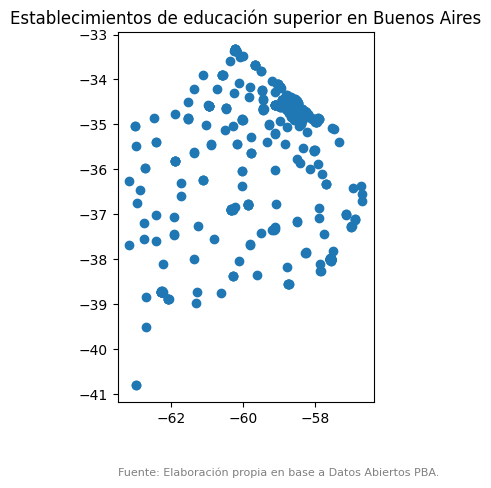

In [70]:
mapa_educ = superior.plot()
mapa_educ.set_title('Establecimientos de educación superior en Buenos Aires')
mapa_educ.text(0, -0.2, 'Fuente: Elaboración propia en base a Datos Abiertos PBA.', transform=mapa_educ.transAxes, fontsize=8, color='gray')
plt.show()


En la misma línea, se chequea la distribución del DF de pobreza crónica por partido:  

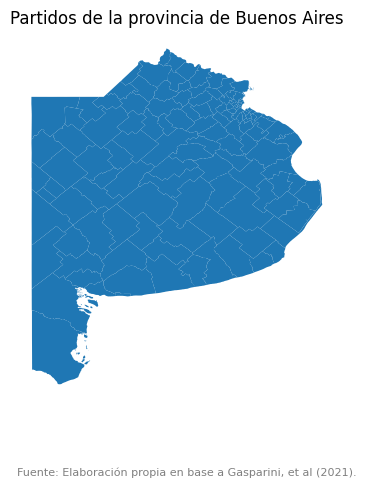

In [71]:
mapa_pobreza = pobreza.plot()
mapa_pobreza.set_title('Partidos de la provincia de Buenos Aires')
mapa_pobreza.text(0, -0.2, 'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=mapa_pobreza.transAxes, fontsize=8, color='gray')
mapa_pobreza.set_axis_off()
plt.show()

## 🗾  3. Desigualdad Territorial

Asimismo, con fines exploratorios y buscando indagar las condiciones de desigualdad en la provincia, se chequea la distribución de algunos indicadores a nivel partido. 

Los indicadores elegidos responden a una lectura multidimensional de la vulnerabilidad socioeconómica, contemplando tres tipos de dimensiones: **educación, salud y condiciones de vivienda.**

En todos los casos, los rangos para la visualización se establecen a partir de cortes naturales. 

### A. Densidad poblacional

En primera instancia se visualiza la distribución de población en la provincia. 

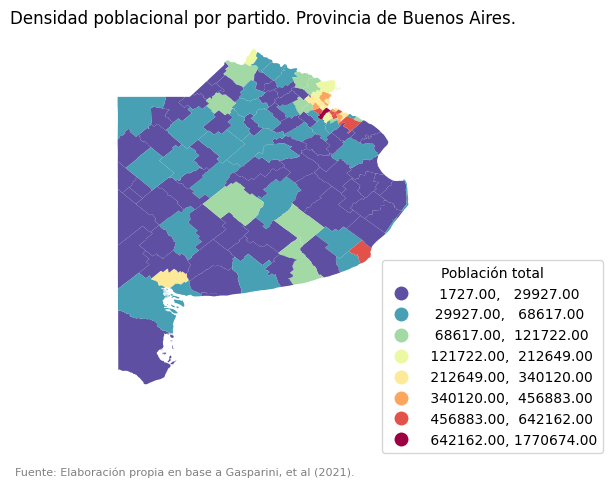

In [72]:

pobreza_poblacion_mapa = pobreza.plot(column='Población', cmap='Spectral_r', legend=True, k=8, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_poblacion_mapa.set_title('Densidad poblacional por partido. Provincia de Buenos Aires.')
pobreza_poblacion_mapa.text(0, -0.2, 'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=pobreza_poblacion_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
#ajusto la leyenda
legend = pobreza_poblacion_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Población total')
pobreza_poblacion_mapa.set_axis_off()


En el mapa previo queda expuesta la mancha urbana del Gran Buenos Aires (GBA), haciendo evidente que la mayor concentración de población se da en esta región de la provincia. 

### B. Porcentaje de Hogares con Pobreza Crónica

Por otro lado, se visualiza la distribución de hogares con pobreza crónica en valores porcentuales por partido. 

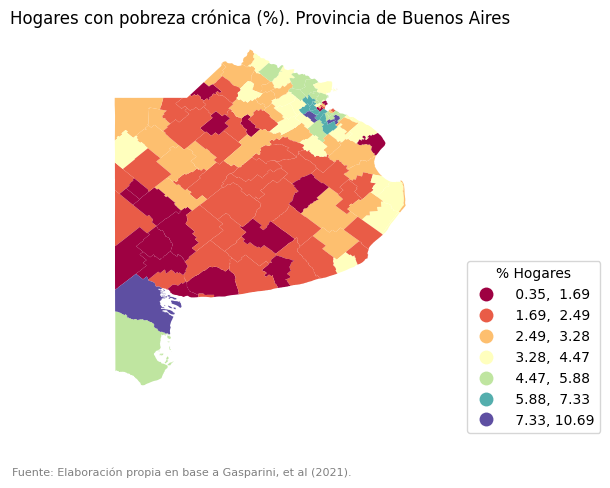

In [73]:
hogares_pc_mapa = pobreza.plot(column='% Hogares en situación de pobreza crónica', cmap='Spectral', legend=True, k=7, scheme = 'Fisher_Jenks',linewidth=0.1)
hogares_pc_mapa.set_title('Hogares con pobreza crónica (%). Provincia de Buenos Aires')
hogares_pc_mapa.text( 0, -0.2,'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=hogares_pc_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
#ajustar la leyenda
legend = hogares_pc_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('% Hogares')
hogares_pc_mapa.set_axis_off()

Considerando ambos mapas, es posible notar que los partidos con mayor concentración poblacional también registran un mayor porcentaje de hogares con pobreza crónica. 

Asimismo, puede verse la profunda desigualdad que subyace a la provincia en términos de la división partidos del interior y del Gran Buenos Aires. Mientras que en el Gran Buenos Aires la mayoría de los partidos registran más de 5% de hogares con pobreza crónica, en el interior se d ala situación inversa y sólo 2 partidos cuentan con valores marcadamente distintos del resto. 

### C. Porcentaje de Hogares con jefe con primaria completa o menos  

A los fines de continuar explorando la desigualdad territorial, se visualiza la distribución de partidos según el % Hogares con jefe con primaria completa o menos.  

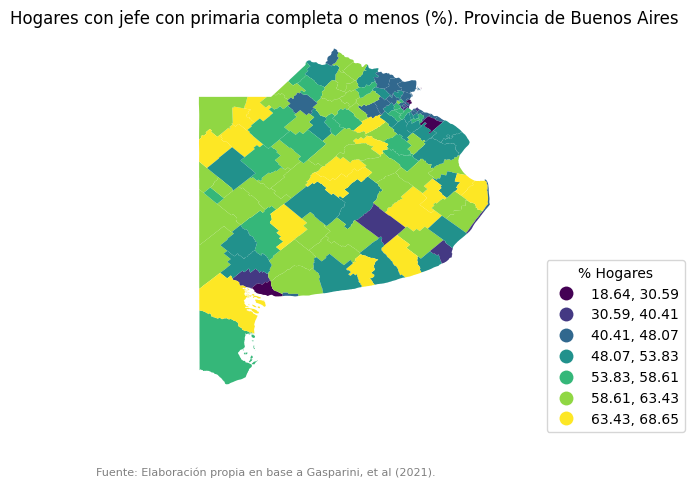

In [74]:
hogares_jp_mapa = pobreza.plot(column='% Hogares con jefe con primaria completa o menos', cmap='viridis', legend=True, k=7, scheme = 'Fisher_Jenks',linewidth=0.1)
hogares_jp_mapa.set_title('Hogares con jefe con primaria completa o menos (%). Provincia de Buenos Aires')
hogares_jp_mapa.text( 0, -0.2,'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=hogares_jp_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
#ajusto la leyenda
legend = hogares_jp_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('% Hogares')
hogares_jp_mapa.set_axis_off()

En términos educativos, es posible notar mediante este indicador que los valores más críticos (63% al 69%) se encuentran en partidos del interior de la provincia. 

Sin embargo, en el GBA también se advierte una gran cantidad de partidos con valores altos (59% al 63%). 

### D. Porcentaje de personas sin obra social ni prepaga   

Seguidamente, se visualiza la distribución relativa de personas sin cobertura de salud en los distintos partidos para contemplar las condiciones de vulnerabilidad en términos de salud. 

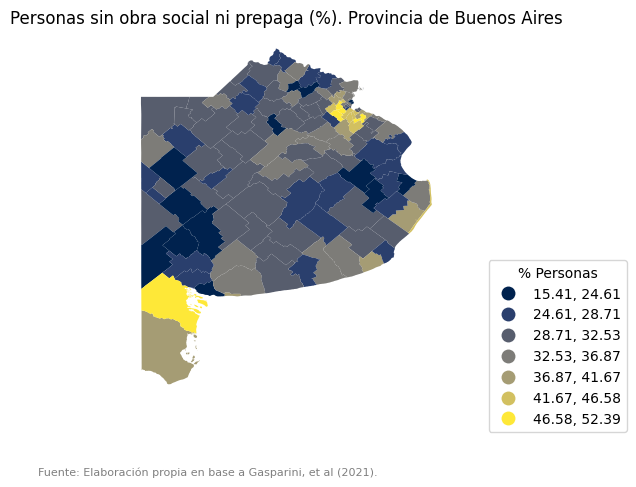

In [75]:
personas_salud_mapa = pobreza.plot(column='% Personas sin obra social ni prepaga', cmap='cividis', legend=True, k=7, scheme = 'Fisher_Jenks',linewidth=0.1)
personas_salud_mapa.set_title('Personas sin obra social ni prepaga (%). Provincia de Buenos Aires')
personas_salud_mapa.text( 0, -0.2,'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=personas_salud_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
#ajusto la leyenda
legend = personas_salud_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('% Personas')
personas_salud_mapa.set_axis_off()

El comportamiento de este indicador es análogo al del primero, siendo evidente que los mayores porcentajes de personas sin conbertura de salud se concentran en el GBA y en una porción minoritaria del Interior. 

### E. Porcentaje de hogares en vivienda precaria

Por último, se analiza una última dimensión de vulnerabilidad vinculada a las condiciones de vivienda mediante la distribución de porcentaje de hogares que habitan viviendas precarias por partido. 

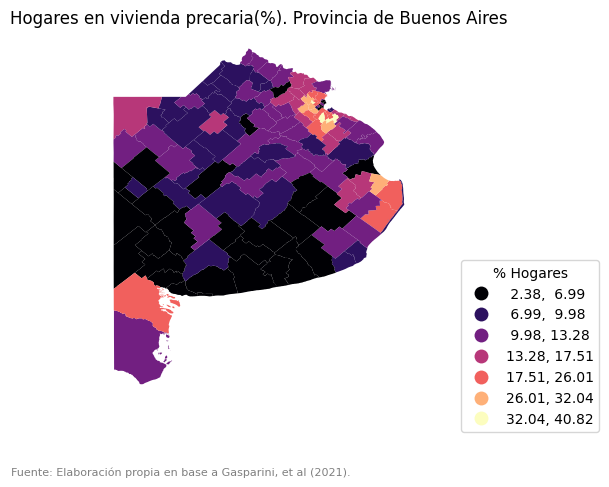

In [76]:
vivienda_mapa = pobreza.plot(column='% Hogares en vivienda precaria', cmap='magma', legend=True, k=7, scheme = 'Fisher_Jenks',linewidth=0.1)
vivienda_mapa.set_title('Hogares en vivienda precaria(%). Provincia de Buenos Aires')
vivienda_mapa.text( 0, -0.2,'Fuente: Elaboración propia en base a Gasparini, et al (2021).', transform=vivienda_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
#ajusto la leyenda
legend = vivienda_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('% Hogares')
vivienda_mapa.set_axis_off()

En este indicador se percibe una distribución heterogénea al interior de la provincia, siendo algo superior la cantidad de partidos que comprenden valores elevados en la distribución relativa de hogares que habitan viviendas precarias. 

En el GBA, por el contrario, se aprecia una concentración de partidos donde los valores del indicador son altos en la mayor parte de los casos. 

En general, los indicadores explorados dan cuenta de una condiciones socioeconómicas muy distintas en la provincia, fundalmente tomando en consideración la distribución según el Interior y el Gran Buenos Aires. 

## 📈 4.Relación entre cantidad de Establecimientos y Desigualdad Territorial

Habiendo indagado las distintas dimensiones de vulnerabilidad socioecnómica, es posible avanzar en relacionarlos con la cantidad y tipo de establecimientos. Para ello, es necesario joinear ambos df. 

In [77]:
pobreza.head(3)


,Código de departamento Link,Provincia,Nombre del departamento,Hogares en situación de pobreza crónica,Personas en situación de pobreza crónica,% Personas en situación de pobreza crónica,% Hogares en situación de pobreza crónica,Nivel de Incidencia de pobreza crónica,Hogares,Población,...,Código de provincia,Nombre de provincia,Código de departamentos/comuna,Nombre de departamentos/comuna,Población total,Total de hogares,Latitud del centroide,Longitud del centroide,Superficie en km2,Geometría en GeoJSON
15,6007,6,Adolfo Alsina,113,689,4.082963,1.811768,2,6237,16875,...,6,Buenos Aires,6007,Adolfo Alsina,17072,6237,-37.197150,-63.055734,5881.601682,"POLYGON ((-63.20661 -36.67023, -63.16748 -36.7..."
16,6014,6,Adolfo Gonzales Chaves,75,450,3.775801,1.786140,2,4199,11918,...,6,Buenos Aires,6014,Adolfo Gonzales Chaves,12047,4199,-37.964953,-60.248503,3787.325302,"POLYGON ((-60.35934 -37.74855, -60.32281 -37.7..."
17,6021,6,Alberti,43,290,2.742317,1.123302,2,3828,10575,...,6,Buenos Aires,6021,Alberti,10654,3828,-35.037399,-60.281935,1120.829651,"POLYGON ((-60.29131 -34.78621, -60.26013 -34.8..."


In [78]:
superior.head(3)

,row_number,idserv,clave,cueanexo,nombre,id_modalid,modalidad,id_nivel,nivel,id_periodo,...,seccion_el,sede_axo_e,esc_sede,cue,anexo,nro_escuel,latitud,longitud,cui,geometry
2,3.0,1,0001AD0003,061060000,ESCUELA DE DANZAS CLASICAS Nº3,4,Modalidad Artística,4,Nivel Superior (**),100,...,8,SEDE,NaN,610600,0,0003,-34.917432,-57.947606,600100011,POINT (-57.94761 -34.91743)
6,7.0,7,0001AM0001,060794600,"CONSERVATORIO DE MÚSICA ""GILARDO-GILARDI""",4,Modalidad Artística,4,Nivel Superior (**),100,...,8,SEDE,NaN,607946,0,0001,-34.898111,-57.985056,600100053,POINT (-57.98506 -34.89811)
8,9.0,8,0001AT0004,061288400,ESCUELA DE TEATRO LA PLATA,4,Modalidad Artística,4,Nivel Superior (**),100,...,8,SEDE,NaN,612884,0,0004,-34.911834,-57.945508,600100069,POINT (-57.94551 -34.91183)


Habiendo chequeado las columnas de cada DF, se procede a unirlos a partir de sus datos geográficos:

In [99]:
puntos = gpd.GeoDataFrame(superior, geometry=gpd.points_from_xy(superior.longitud, superior.latitud))
poligonos = gpd.GeoDataFrame(pobreza)

In [100]:
poligonos = poligonos.set_crs("EPSG:4326", inplace=True)

In [101]:
unido = gpd.sjoin(puntos, poligonos, op='within')

/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py:3473: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


Se verifican los primeros 20 y 40 casos para chequear que la unión es correcta, contemplando sólo aquellas columnas que registran valores vinculados a la ubicación: 

In [81]:
pd.DataFrame({'Columna': unido.columns})

,Columna
0,row_number
1,idserv
2,clave
3,cueanexo
4,nombre
...,...
78,Población total
79,Total de hogares
80,Latitud del centroide
81,Longitud del centroide


In [82]:
(unido[unido.columns[[19,20,21,57,58]]]).head(20)

,distrito,region,region_edu,Provincia,Nombre del departamento
2,La Plata,01,Región I,6,La Plata
6,La Plata,01,Región I,6,La Plata
8,La Plata,01,Región I,6,La Plata
12,La Plata,01,Región I,6,La Plata
117,La Plata,01,Región I,6,La Plata
118,La Plata,01,Región I,6,La Plata
119,La Plata,01,Región I,6,La Plata
120,La Plata,01,Región I,6,La Plata
121,La Plata,01,Región I,6,La Plata
122,La Plata,01,Región I,6,La Plata


In [83]:
(unido[unido.columns[[19,20,21,57,58]]]).tail(20)

,distrito,region,region_edu,Provincia,Nombre del departamento
12620,Hurlingham,07,Región VII,4,Hurlingham
15801,Hurlingham,07,Región VII,4,Hurlingham
21125,Hurlingham,07,Región VII,4,Hurlingham
13236,Hipólito Yrigoyen,15,Región XV,6,Hipolito Yrigoyen
14536,Villa Gesell,18,Región XVIII,6,Villa Gesell
15863,Villa Gesell,18,Región XVIII,6,Villa Gesell
21010,Villa Gesell,18,Región XVIII,6,Villa Gesell
21458,Villa Gesell,18,Región XVIII,6,Villa Gesell
14818,Malvinas Argentinas,09,Región IX,4,Malvinas Argentinas
21140,Malvinas Argentinas,09,Región IX,4,Malvinas Argentinas


### A. Cantidad de establecimientos por partido


En un primer momento, se chequean cuántos establecimientos existe en el DF para verificar que no existan casos duplicados mediante su atributo único (clave): 

In [84]:
 unido['clave'].nunique()

638

Se observa que existen 638 establecimientos, dato que se puedecontrastar con las filas del df.

In [85]:
unido.shape

(638, 83)

Se verifica que existen tantas filas como establecimientos, por lo que es posible avanzar en contar los casos según el partido: 

In [86]:
count = unido['Nombre del departamento'].value_counts()
count.head(12)

La Plata              49
General Pueyrredon    35
Lomas de Zamora       27
La Matanza            22
Bahia Blanca          21
Moron                 18
General San Martin    16
Avellaneda            16
Vicente Lopez         14
Quilmes               14
San Isidro            14
Lanus                 13
Name: Nombre del departamento, dtype: int64

Se visualiza la distribución absoluta.

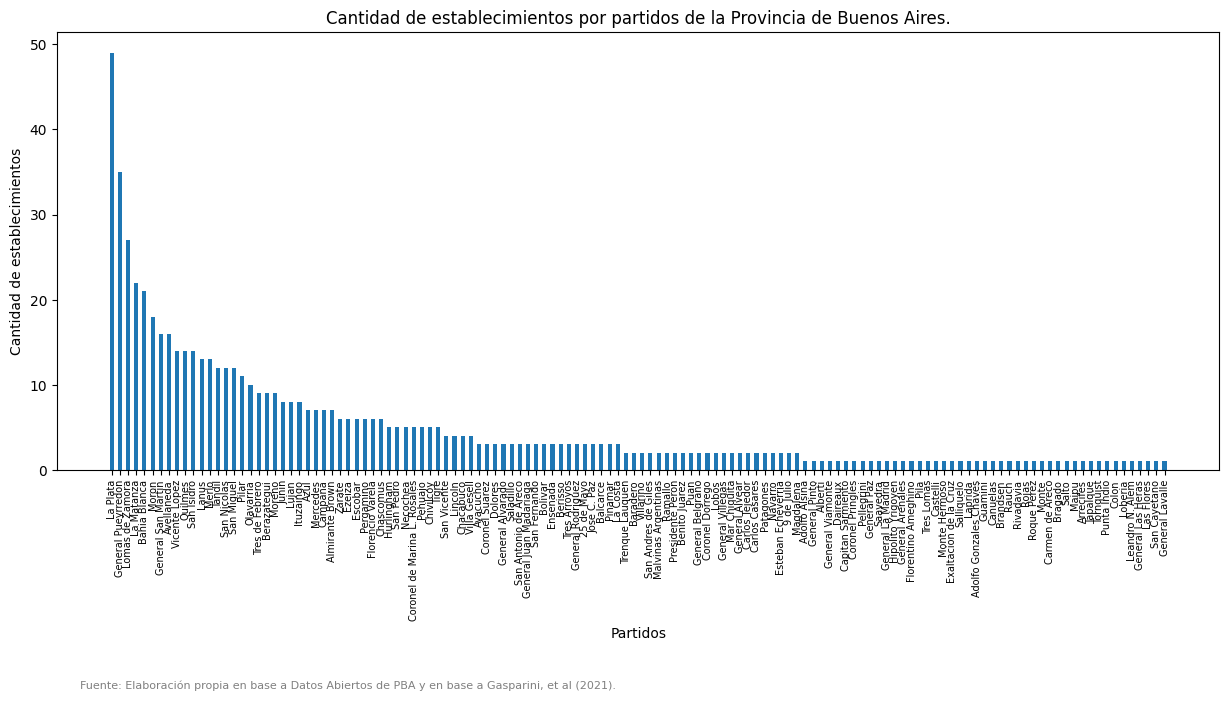

In [87]:
fig = plt.figure(figsize=(15, 6))

plt.bar(count.index, count.values, width=0.5)
plt.title('Cantidad de establecimientos por partidos de la Provincia de Buenos Aires.')
plt.xlabel('Partidos')
plt.ylabel('Cantidad de establecimientos')
plt.xticks(rotation=90, fontsize = 7)
plt.subplots_adjust(bottom=0.15)
plt.text(0.02, -0.5, 'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=plt.gca().transAxes, fontsize=8, color='gray')
plt.show()


Es posible observar que la distribución es asimétrica y que las mayores 10 frecuencias corresponden, en un 81% de los casos, a partidos del GBA. 

Se visualiza esta distribución en un mapa, volviendo a hacer el cálculo agregado.

In [36]:
agg = unido.groupby('Nombre del departamento').agg({'clave': 'count'}).reset_index()
agg = agg.rename(columns={'clave': 'cant_establecimientos'})
print(agg)

    Nombre del departamento  cant_establecimientos
0                25 de Mayo                      3
1                9 de Julio                      2
2             Adolfo Alsina                      1
3    Adolfo Gonzales Chaves                      1
4                   Alberti                      1
..                      ...                    ...
125         Tres de Febrero                      9
126           Vicente Lopez                     14
127            Villa Gesell                      4
128               Villarino                      2
129                  Zarate                      6

[130 rows x 2 columns]


Se procede a joinear este conteo con el DF de pobreza crónica, dado que esta es la variable que se analizará en relación a los indicadores de vulnerabilidad. 

In [88]:
pobreza_edu = pd.merge(pobreza, agg, on='Nombre del departamento', how='left')
pobreza_edu.head(1)

,Código de departamento Link,Provincia,Nombre del departamento,Hogares en situación de pobreza crónica,Personas en situación de pobreza crónica,% Personas en situación de pobreza crónica,% Hogares en situación de pobreza crónica,Nivel de Incidencia de pobreza crónica,Hogares,Población,...,Nombre de provincia,Código de departamentos/comuna,Nombre de departamentos/comuna,Población total,Total de hogares,Latitud del centroide,Longitud del centroide,Superficie en km2,Geometría en GeoJSON,cant_establecimientos
0,6007,6,Adolfo Alsina,113,689,4.082963,1.811768,2,6237,16875,...,Buenos Aires,6007,Adolfo Alsina,17072,6237,-37.19715,-63.055734,5881.601682,"POLYGON ((-63.20661 -36.67023, -63.16748 -36.7...",1.0


Se chequea que la variable geográfica sigue visualizandose óptimamente: 

<Axes: >

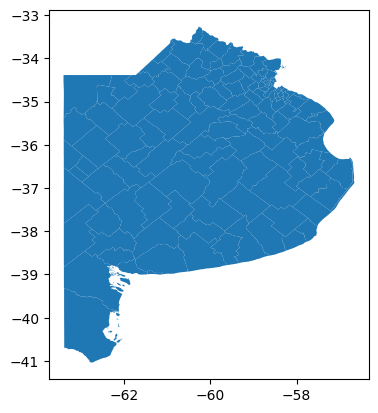

In [89]:
pobreza_edu.plot()

Antes de visualizar, cabe notar que previamente se observó que la cantidad de establecimientos se obtuvo para 130 partidos, por lo que hay 4 para los cuales no se cuenta con información. En esos casos, se reemplazan los valores nulos por 0 para que ello no afecte en el gráfico. 

In [90]:
pobreza_edu['cant_establecimientos'].fillna(0, inplace=True)


Se visualiza la cantidad de establecientos por partido. 

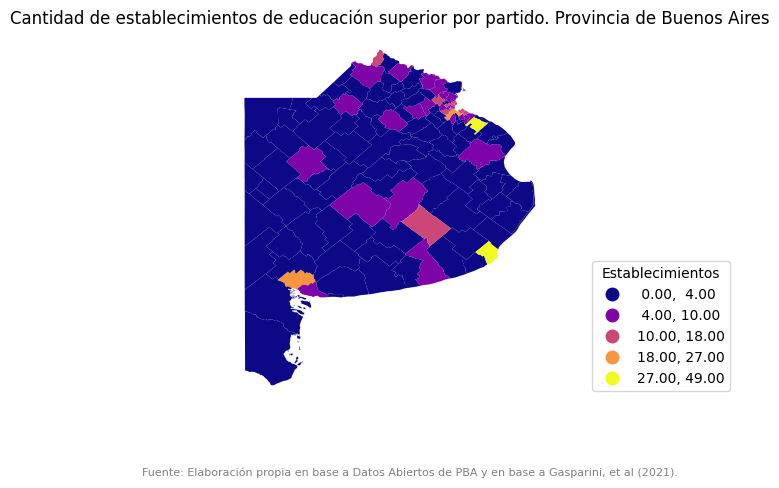

In [91]:
establecimientos_mapa = pobreza_edu.plot(column='cant_establecimientos', cmap='plasma', legend=True, k=5, scheme = 'Fisher_Jenks',linewidth=0.1)
establecimientos_mapa.set_title('Cantidad de establecimientos de educación superior por partido. Provincia de Buenos Aires')
establecimientos_mapa.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=establecimientos_mapa.transAxes, fontsize=8, color='gray')
plt.axis('equal')
legend = establecimientos_mapa.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Establecimientos')
establecimientos_mapa.set_axis_off()

Se observa que los dos partidos con mayor cantidad de establecimientos corresponden tanto al GBA, como al interior de la provincia. 


Se procede entonces a relacionar esta cantidad con los indicadores previamente indagados. 

### B. Relación entre cantidad de establecimientos e indicadores de vulnerabilidad

En los siguientes análisis, se propone un análisis que se vale de distintas estrategias de visualización: 
*  Con el tamaño de los puntos se evidencia la cantidad de establecimientos
*  Con el color de los polígonos se muestran, con un color más claro, los que registran valores más críticos. 

### Porcentaje de Hogares con Pobreza Crónica


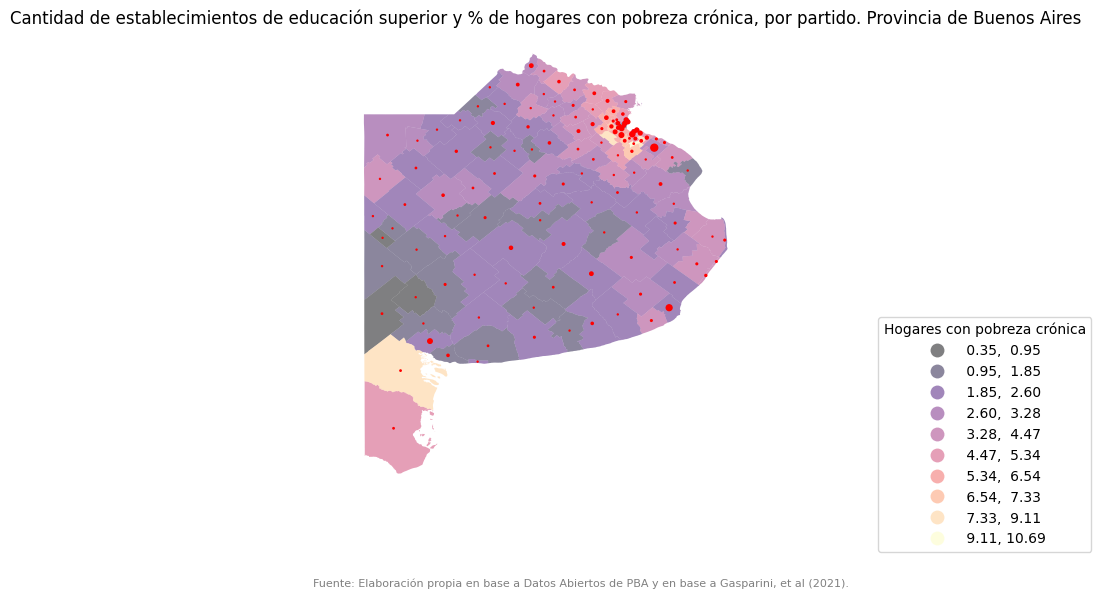

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))
#pobreza_edu.plot(column='cant_establecimientos', cmap='Greys', ax=ax)
pobreza_edu.plot(column='% Hogares en situación de pobreza crónica',  cmap='magma', ax=ax, alpha=0.5, legend=True, k=10, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_edu.centroid.plot(ax=ax, color='red', markersize=pobreza_edu['cant_establecimientos']/2)
#pobreza_edu.geometry.boundary.plot(ax=ax, color='black', alpha=1, linewidth=pobreza_edu['% Hogares en situación de pobreza crónica']/10)
plt.axis('equal')
ax.set_title('Cantidad de establecimientos de educación superior y % de hogares con pobreza crónica, por partido. Provincia de Buenos Aires')
ax.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=ax.transAxes, fontsize=8, color='gray')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Hogares con pobreza crónica')
ax.set_axis_off()

En general, en el interior, puede verse que los partidos donde mayor cantidad de establecimientos existen se corresponden con los que no tienen los valores críticos del indicador. 

En el GBA, en particular, se observa que la mayoría de los partidos registran altos porcentajes de hogares con pobreza crónica y algunos de ellos cuentan también con alta cantidad de establecimientos educativos. Aun así, se aprecia a su vez lo contrario: uno de los partidos que mayor % de hogares con pobreza crónica registra es también uno de los pocos que no cuenta con establecimientos. 

### Porcentaje de hogares con jefe con primaria completa o menos

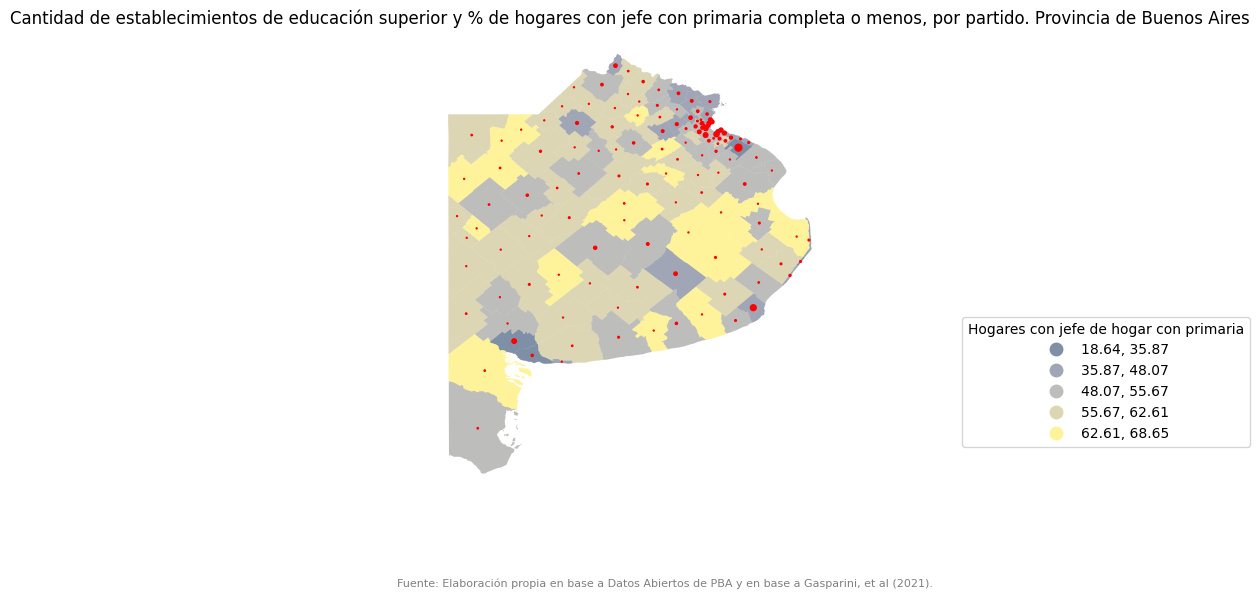

In [43]:
fig, ax = plt.subplots(figsize=(6, 6))

pobreza_edu.plot(column='% Hogares con jefe con primaria completa o menos',  cmap='cividis', ax=ax, alpha=0.5, legend=True, k=5, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_edu.centroid.plot(ax=ax, color='red', markersize=pobreza_edu['cant_establecimientos']/2)

plt.axis('equal')
ax.set_title('Cantidad de establecimientos de educación superior y % de hogares con jefe con primaria completa o menos, por partido. Provincia de Buenos Aires')
ax.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=ax.transAxes, fontsize=8, color='gray')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Hogares con jefe de hogar con primaria')
ax.set_axis_off()

En este punto, a diferencia del resto, se observa que los partidos donde se concentran mayor cantidad de establecimientos, no se corresponden con aquellos en los que el porcentaje del indicador presenta altos valores. 

### Personas sin cobertura médica

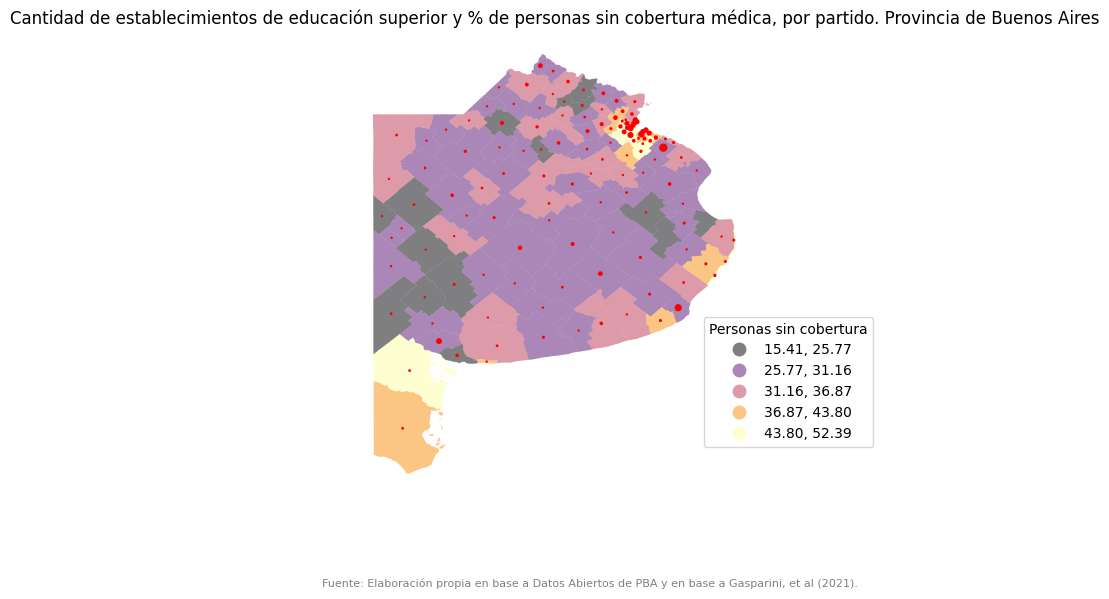

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))

pobreza_edu.plot(column='% Personas sin obra social ni prepaga',  cmap='inferno', ax=ax, alpha=0.5, legend=True, k=5, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_edu.centroid.plot(ax=ax, color='red', markersize=pobreza_edu['cant_establecimientos']/2)

plt.axis('equal')
ax.set_title('Cantidad de establecimientos de educación superior y % de personas sin cobertura médica, por partido. Provincia de Buenos Aires')
ax.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=ax.transAxes, fontsize=8, color='gray')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Personas sin cobertura')
ax.set_axis_off()

Respecto a la relación entre la cobertura de salud y la cantidad de establecimientos, se observa coincidencia en el GBA en los valores altos de los indicadores. Sin embargo, esta relación no se sostiene al prestar atención en los partidos del Interior. 



### Porcentaje de hogares en vivienda precaria

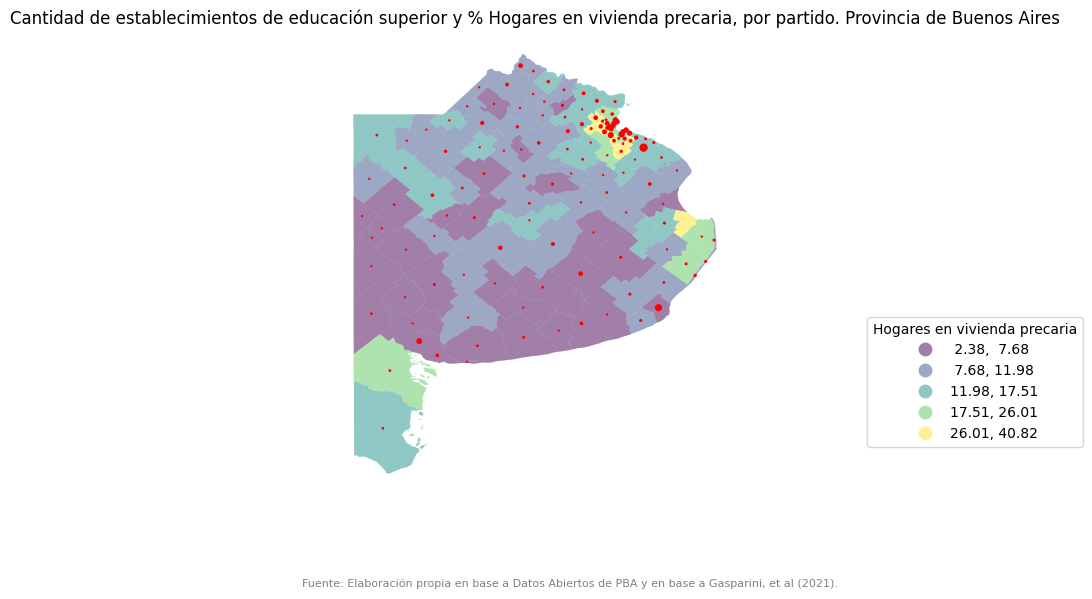

In [45]:
fig, ax = plt.subplots(figsize=(6, 6))


pobreza_edu.plot(column='% Hogares en vivienda precaria',  cmap='viridis', ax=ax, alpha=0.5, legend=True, k=5, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_edu.centroid.plot(ax=ax, color='red', markersize=pobreza_edu['cant_establecimientos']/2)

plt.axis('equal')
ax.set_title('Cantidad de establecimientos de educación superior y % Hogares en vivienda precaria, por partido. Provincia de Buenos Aires')
ax.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=ax.transAxes, fontsize=8, color='gray')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Hogares en vivienda precaria')
ax.set_axis_off()




La observación del indicador anterior aplica al comportamiento de este indicador, siendo evidente que los partidos del interior con mayor porcentaje no cuentan con las mismas condiciones que los del GBA en lo que respecta a las condiciones de vivienda. 

### Nivel de incidencia de pobreza crónica

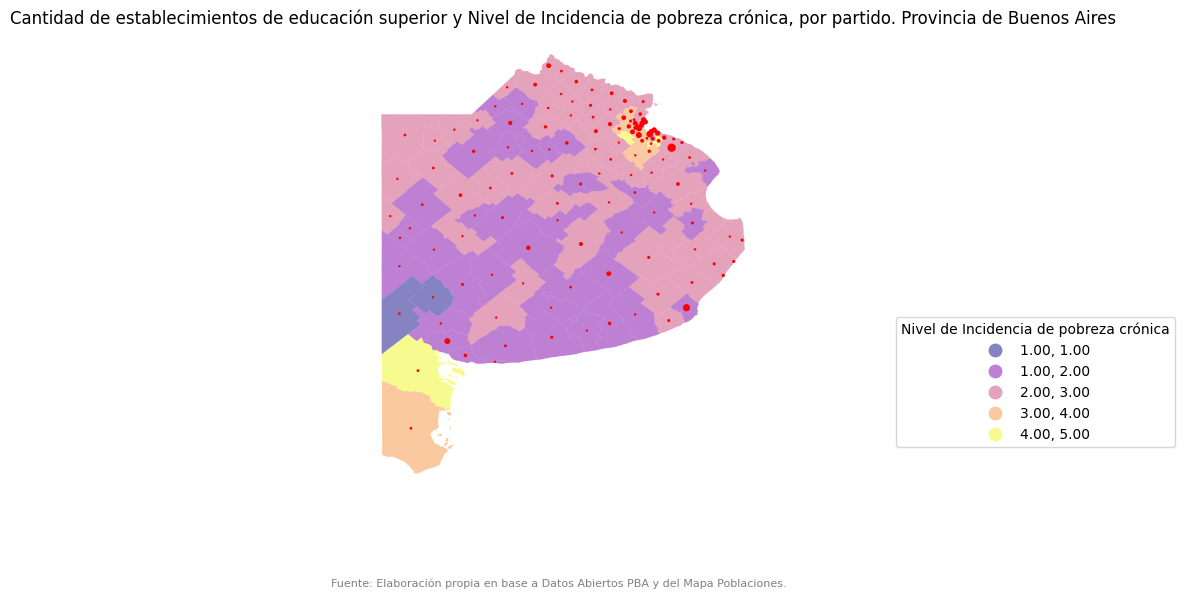

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))

pobreza_edu.plot(column='Nivel de Incidencia de pobreza crónica',  cmap='plasma', ax=ax, alpha=0.5, legend=True, scheme = 'Fisher_Jenks',linewidth=0.1)
pobreza_edu.centroid.plot(ax=ax, color='red', markersize=pobreza_edu['cant_establecimientos']/2)

plt.axis('equal')
ax.set_title('Cantidad de establecimientos de educación superior y Nivel de Incidencia de pobreza crónica, por partido. Provincia de Buenos Aires')
ax.text( 0, -0.2,'Fuente: Elaboración propia en base a Datos Abiertos de PBA y en base a Gasparini, et al (2021).', transform=ax.transAxes, fontsize=8, color='gray')
legend = ax.get_legend()
legend.set_bbox_to_anchor((1.2, 0.4))
legend.set_title('Nivel de Incidencia de pobreza crónica')
ax.set_axis_off()

Finalmente, se observa la relación entre niveles de pobreza crónica y la cantidad de establecimientos donde se resumen lo encontrado previamente: en el GBA

## 🧐 5.Conclusiones

> El análisis propuesto sugiere que las condiciones socioeconómicas de la población de la provincia no son las mismas para quienes residen en el Interior, respcto a quienes lo hacen en el GBA. En general, la mayoría de los valores críticos de los indicadores de vulnerabilidad registran mayor presencia en este último y resultan excepcionales en el Interior.

> Sin embargo, en la dimensión educativa se aprecia otra posible lectura. En este sentido, al indagar el porcentaje de hogares con jefe con primaria completa o menos, se encontraron mayores valores críticos en el Interior, mientras que algunos de los valores más bajos se identificaron en el GBA (19 a 31%). 

> Asimismo, al comparar dicho porcentaje con la cantidad de establecimientos educativos, no se encuentran coincidencias. Es decir, aquellos partidos donde los jefes de hogar poseen -relativamente- menor formación, no son los mismos en los cuales existen mayor cantidad de instituciones educativas. Ello implica que una mayor cantidad de establecimientos se corresponde con un menor porcentaje de jefes de hogar con primaria completa o menos. 

> De tal modo, el análisis abre posibilidades de futuros abordajes que puedan profundizar en el acceso a la educación superior y su impacto en la población de la provincia de Buenos Aires, fundamentalmente a partir de la creación de un gran número de universidades nacionales en el GBA. 



## 📚 6.Bibliografía y recursos 

*   Gasparini, L., et al (2021). Cartografía de Pobreza Crónica. Disponible [aquí](hhttps://mapa.poblaciones.org/services/metadata/GetWorkMetadataPdf?m=46701&d=86601&w=42901).

